In [1]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import functools
import operator

In [2]:
weather_data = pd.read_csv('Plant_1_Weather_Sensor_Data.csv')
gen_data = pd.read_csv('Plant_1_Generation_Data.csv')

In [3]:
weather_data['DATE_TIME']= pd.to_datetime(weather_data['DATE_TIME'])
gen_data['DATE_TIME']= pd.to_datetime(gen_data['DATE_TIME'], format='%d-%m-%Y %H:%M')

In [4]:
weather_data['DAY'] = pd.DatetimeIndex(weather_data['DATE_TIME']).dayofyear
weather_data['TIME'] = weather_data.DATE_TIME.dt.hour * 60 + weather_data.DATE_TIME.dt.minute
weather_data['Time'] = weather_data.DATE_TIME.dt.time
weather_data['HOUR'] = weather_data.DATE_TIME.dt.hour
weather_data.head()

,DATE_TIME,PLANT_ID,SOURCE_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:15:00,4135001,HmiyD2TTLFNqkNe,25.084589,22.761668,0.0,136,15,00:15:00,0
2,2020-05-15 00:30:00,4135001,HmiyD2TTLFNqkNe,24.935753,22.592306,0.0,136,30,00:30:00,0
3,2020-05-15 00:45:00,4135001,HmiyD2TTLFNqkNe,24.846130,22.360852,0.0,136,45,00:45:00,0
4,2020-05-15 01:00:00,4135001,HmiyD2TTLFNqkNe,24.621525,22.165423,0.0,136,60,01:00:00,1


In [5]:
merged_df = pd.merge(gen_data, weather_data, how='inner', on=['DATE_TIME'], suffixes=('', '_y'))
merged_df

,DATE_TIME,PLANT_ID,SOURCE_KEY,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,TIME,Time,HOUR
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.000,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.000,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.000,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.000,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,136,0,00:00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68769,2020-06-17 23:45:00,4135001,uHbuxQJl8lW7ozc,0.0,0.0,5967.000,7287002.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23
68770,2020-06-17 23:45:00,4135001,wCURE6d3bPkepu2,0.0,0.0,5147.625,7028601.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23
68771,2020-06-17 23:45:00,4135001,z9Y9gH1T5YWrNuG,0.0,0.0,5819.000,7251204.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23
68772,2020-06-17 23:45:00,4135001,zBIq5rxdHJRwDNY,0.0,0.0,5817.000,6583369.0,4135001,HmiyD2TTLFNqkNe,21.909288,20.427972,0.0,169,1425,23:45:00,23


## Plot irradiation vs DC power for a single inverter for all days

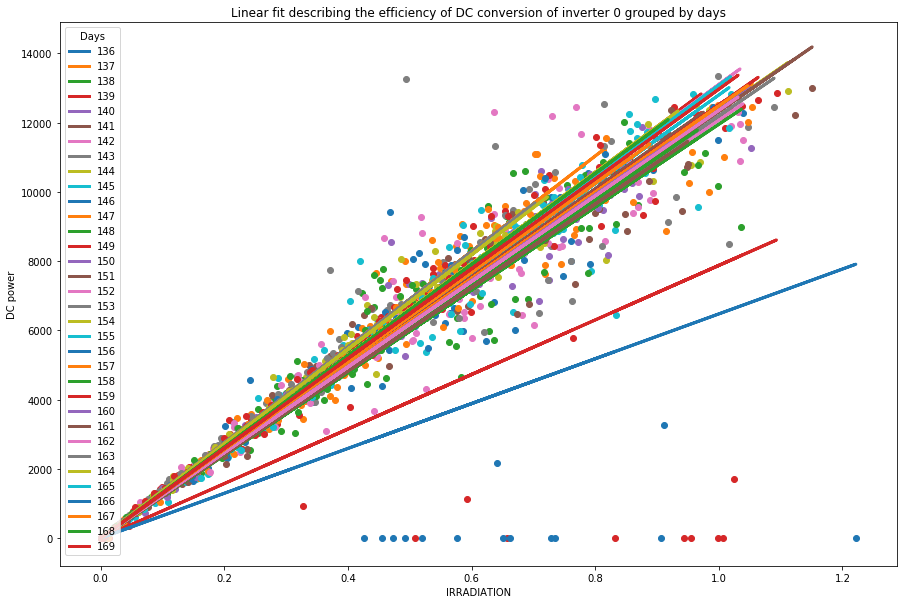

In [6]:
coeff=[]
inv0=merged_df[merged_df.SOURCE_KEY==merged_df.SOURCE_KEY[0]]
plt.figure(figsize=(15, 10))
for a, day in inv0.groupby(inv0.DAY):
    X = day['IRRADIATION'].values.reshape(-1,1)
    y = day['DC_POWER'].values.reshape(-1,1)
    regressor = LinearRegression(fit_intercept=False)
    plt.scatter(day['IRRADIATION'], day['DC_POWER'])
    regressor.fit(X, y)
    m=regressor.coef_
    result = []
    [result.extend(el) for el in m] 
    E=[]
    for el in result:
        E.append(el)
    plt.plot(day['IRRADIATION'], E*day['IRRADIATION'] , linewidth=3)
    coeff.append(E)
    coefficients = pd.DataFrame(data=np.array(coeff), columns=['lin_fit_coeff'])
coefficients['DAY'] = merged_df['DAY'].unique()
plt.legend(inv0.DAY.unique(), loc="upper left", title="Days")
plt.xlabel('IRRADIATION')
plt.ylabel('DC power')
plt.title("Linear fit describing the efficiency of DC conversion of inverter 0 grouped by days")
plt.show()

In [7]:
#Removing the outliers to have a better fit of the data
clean_data=merged_df.copy()
for i, j in  clean_data.groupby(clean_data.HOUR):
    outlier_condition1=j['DC_POWER']>=(j['DC_POWER'].mean()+ 3*j['DC_POWER'].std())
    outlier_condition2=j['DC_POWER']<(j['DC_POWER'].mean()- 3*j['DC_POWER'].std())
    clean_data.drop(clean_data.loc[(clean_data['DAY'].isin(j.loc[outlier_condition1|outlier_condition2].DAY))&(clean_data['HOUR']==i)].index, inplace=True)

<Figure size 1080x720 with 0 Axes>

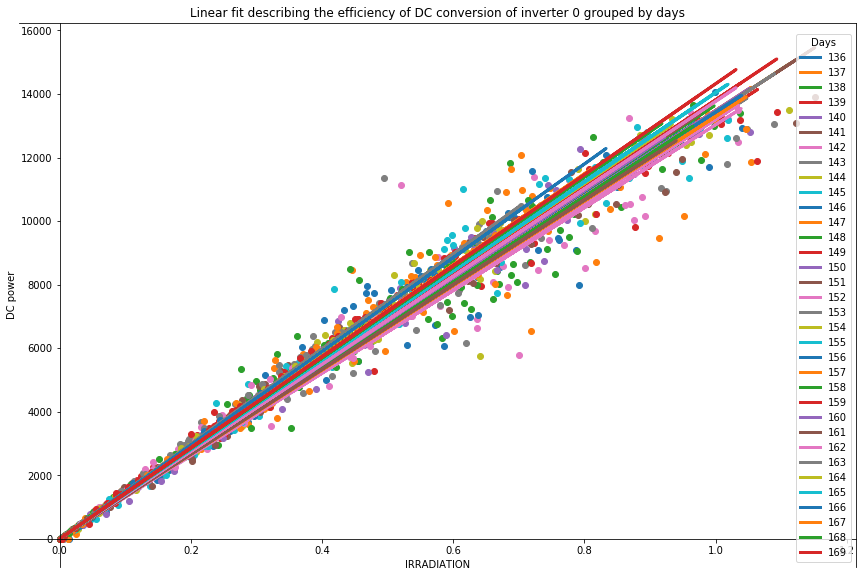

In [8]:
coeff=[]
inv0=clean_data[clean_data.SOURCE_KEY==clean_data.SOURCE_KEY.unique()[1]]
plt.figure(figsize=(15, 10))
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.spines['left'].set_position(('data', 0))
ax.spines['bottom'].set_position(('data', 0))
for a, day in inv0.groupby(inv0.DAY):
    X = day['IRRADIATION'].values.reshape(-1,1)
    y = day['DC_POWER'].values.reshape(-1,1)
    regressor = LinearRegression(fit_intercept=False)
    plt.scatter(day['IRRADIATION'], day['DC_POWER'])
    regressor.fit(X, y)
    m=regressor.coef_
    result = []
    [result.extend(el) for el in m] 
    E=[]
    for el in result:
        E.append(el)
    plt.plot(day['IRRADIATION'], E*day['IRRADIATION'] , linewidth=3)
    coeff.append(E)
    coefficients = pd.DataFrame(data=np.array(coeff), columns=['lin_fit_coeff'])
coefficients['DAY'] = merged_df['DAY'].unique()
plt.legend(inv0.DAY.unique(), loc="lower right", title="Days")
plt.xlabel('IRRADIATION')
plt.ylabel('DC power')
plt.title("Linear fit describing the efficiency of DC conversion of inverter 0 grouped by days")
plt.show()

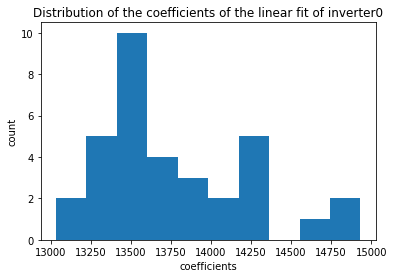

In [9]:
plt.hist(coefficients['lin_fit_coeff'])
plt.title('Distribution of the coefficients of the linear fit of inverter0')
plt.xlabel('coefficients')
plt.ylabel('count')
plt.show()

## Write a function that given the dataframe as input calculates the coefficients for every day and every inverter and returns a dataframe with the following columns Date, Inverter, Conversion_coeff.

In [10]:
def Irr_ac_linear_fit(data):
    coeff=[]
    days=[]
    inverters=[]
    for i in data.SOURCE_KEY.unique():
        inv_data=data[data.SOURCE_KEY==i]
        for a, day in inv_data.groupby(inv_data.DAY):
            inverters.append(i)
            INV=pd.DataFrame(data=np.array(inverters), columns=['Inverter'])
            days.append(a)
            DAYS=pd.DataFrame(data=np.array(days), columns=['Day'])
            X = day['IRRADIATION'].values.reshape(-1,1)
            y = day['DC_POWER'].values.reshape(-1,1)
            regressor = LinearRegression(fit_intercept=False)
            regressor.fit(X, y)
            m=regressor.coef_
            result = []
            [result.extend(el) for el in m] 
            E=[]
            for el in result:
                E.append(el)
            coeff.append(E)
            coefficients = pd.DataFrame(data=np.array(coeff), columns=['Conversion_coeff'])
            conv = [INV, DAYS, coefficients]
            conversion_data = pd.concat(conv, axis=1)
    return(conversion_data)

In [11]:
conversion_data=Irr_ac_linear_fit(clean_data)
conversion_data.head()

,Inverter,Day,Conversion_coeff
0,1BY6WEcLGh8j5v7,136,12354.989316
1,1BY6WEcLGh8j5v7,137,13795.526206
2,1BY6WEcLGh8j5v7,138,12442.529876
3,1BY6WEcLGh8j5v7,139,13206.622964
4,1BY6WEcLGh8j5v7,140,12853.514593


#### Study this dataframe by looking at one inverters coefficients over the month and see if you can recognise variations in the inverters coefficients in the original DC power against time plot.

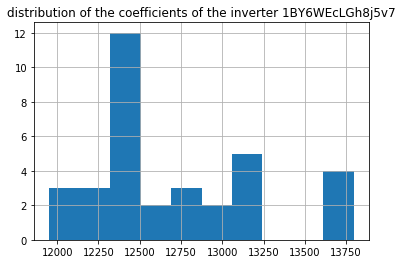

In [12]:
inv0=conversion_data[conversion_data.Inverter== conversion_data.Inverter.unique()[0]]
inv0.Conversion_coeff.hist()
plt.title('distribution of the coefficients of the inverter '+ inv0.Inverter[0])
plt.show()

In [13]:
print(inv0[inv0.Conversion_coeff ==inv0.Conversion_coeff.max()])
print(inv0[inv0.Conversion_coeff==inv0.Conversion_coeff.min()])

          Inverter  Day  Conversion_coeff
1  1BY6WEcLGh8j5v7  137      13795.526206
           Inverter  Day  Conversion_coeff
12  1BY6WEcLGh8j5v7  148      11952.752813


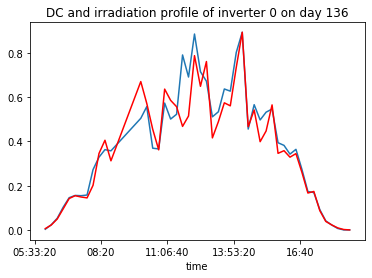

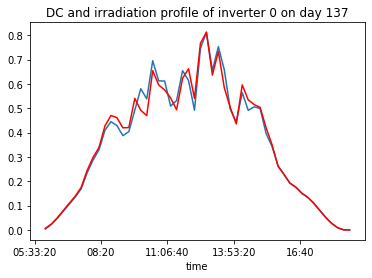

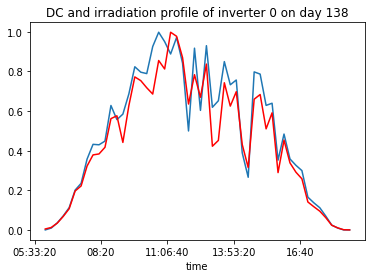

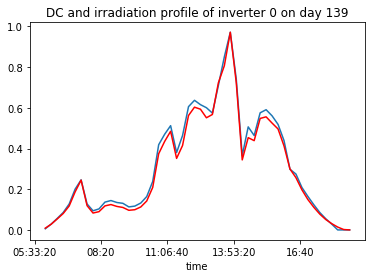

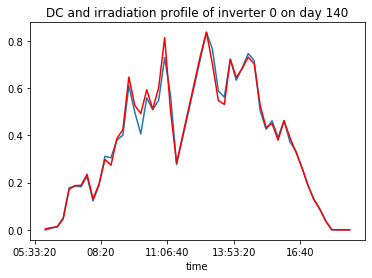

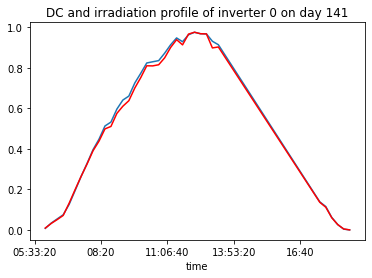

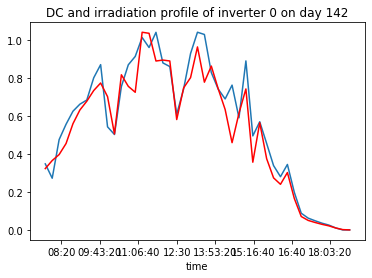

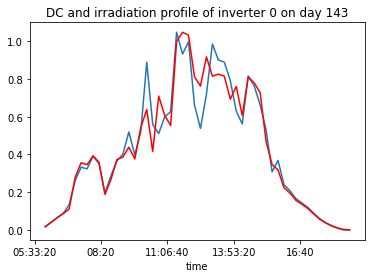

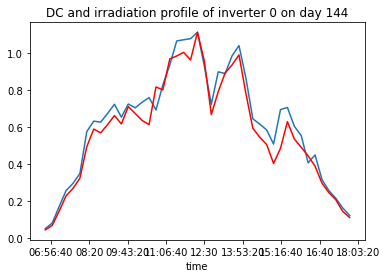

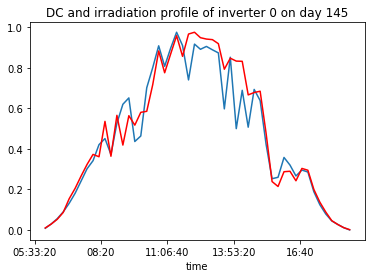

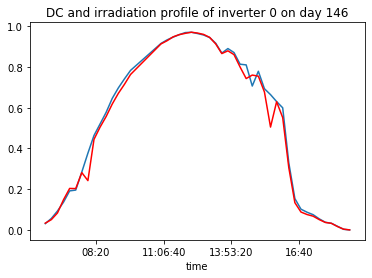

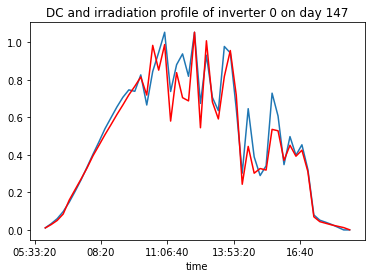

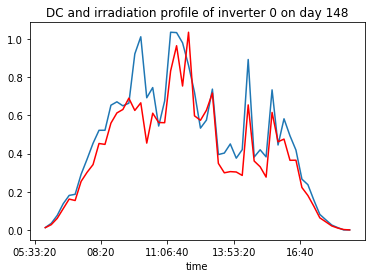

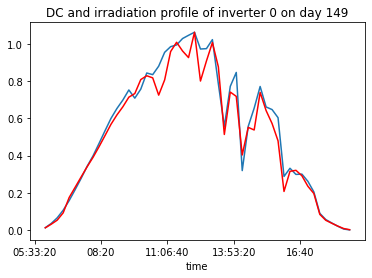

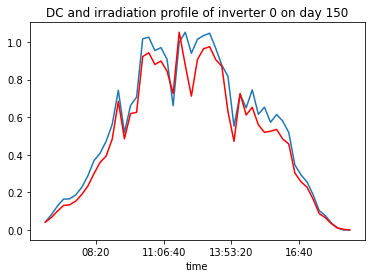

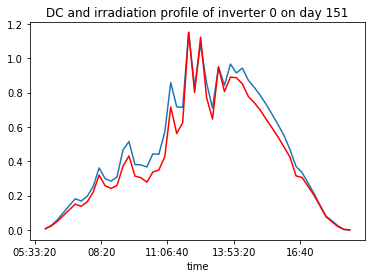

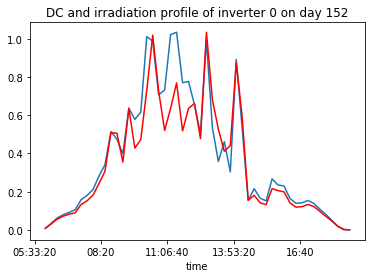

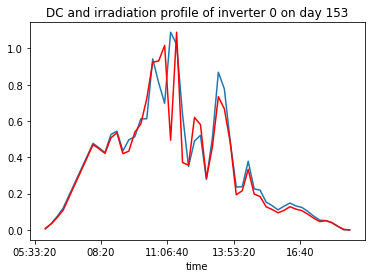

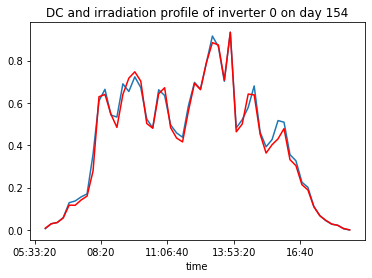

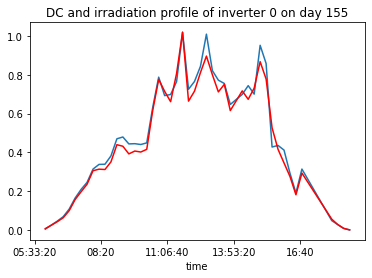

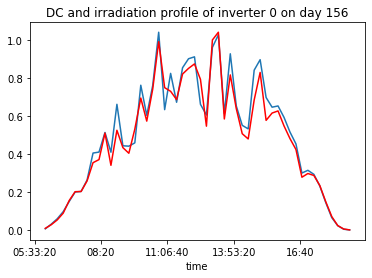

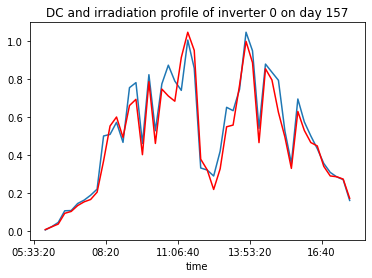

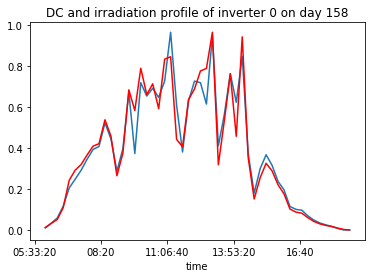

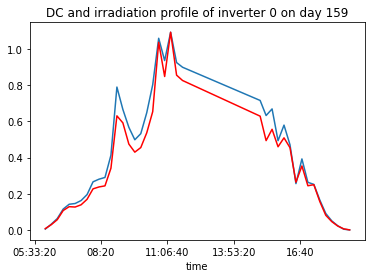

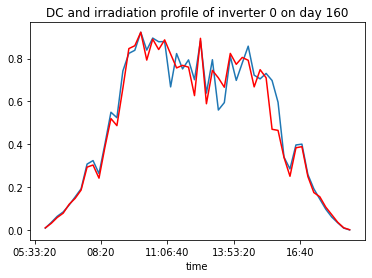

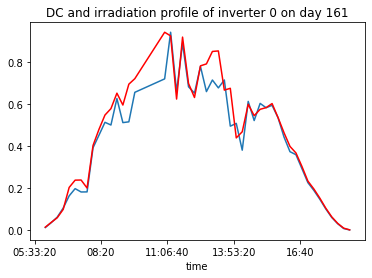

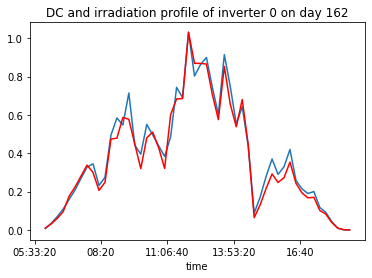

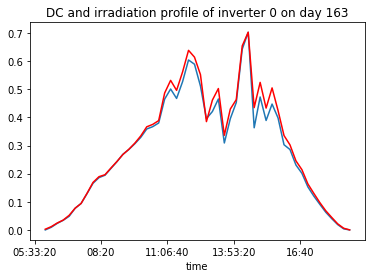

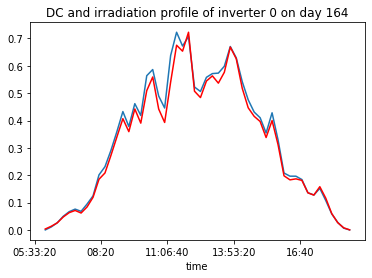

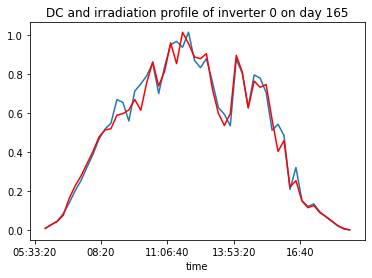

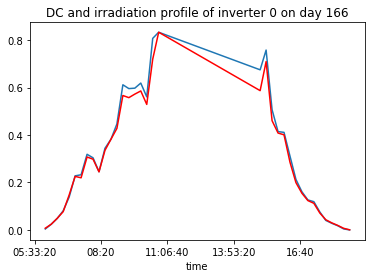

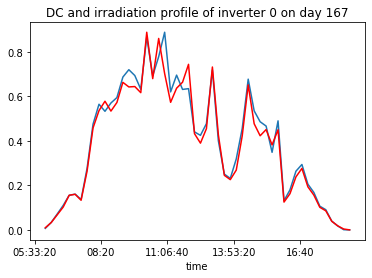

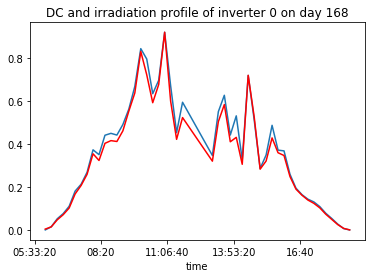

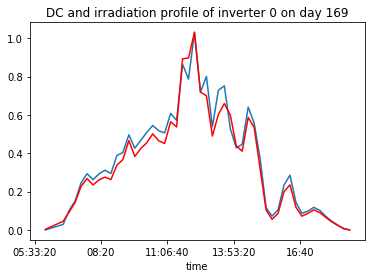

In [14]:
inverter0=clean_data[clean_data.SOURCE_KEY==inv0.Inverter[0]]
for a, day in inverter0.groupby(inverter0.DAY):
#     plt.figure(figsize=(15, 10))
    scale = day.IRRADIATION.max() / day.DC_POWER.max()
    plt.plot(day.Time, day.DC_POWER*scale)
    plt.plot(day.Time, day.IRRADIATION, color='red')
    
# plt.legend(inverter0.DAY.unique())
    plt.title('DC and irradiation profile of inverter 0 on day '+str(a))
    plt.show()

I tried to look at the DC against time plots alone, but it was not very interesting, because there could be days where the correlation coefficient is high but the DC values are not high. Those happen because of the cloudiness of the day. it is more interesting to look at the days where the correlation coefficient is lower than usual, because that is where a malfunction happens. 

And if we look at the distribution of the coefficients of inverter0, the lowest coefficient is still acceptable.

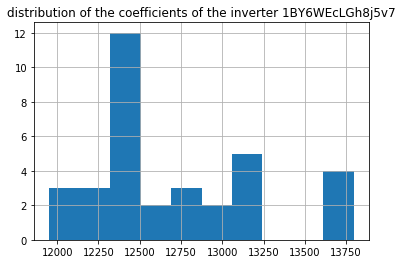

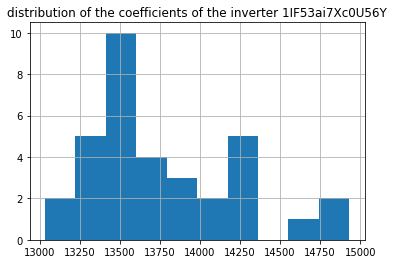

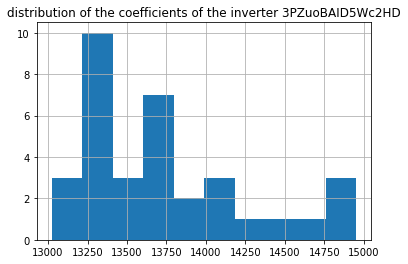

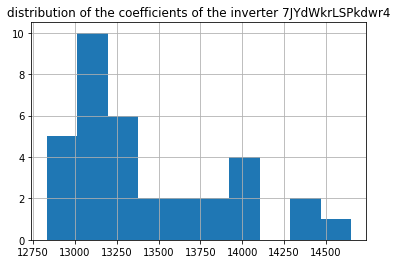

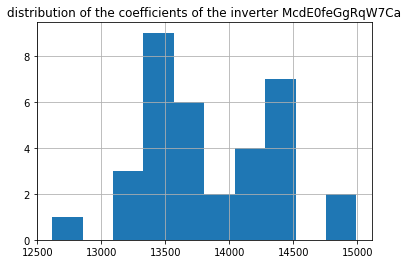

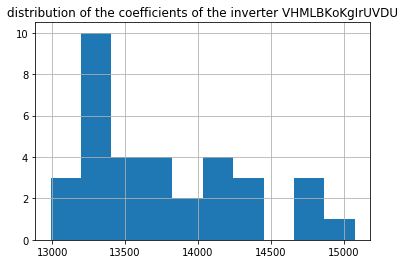

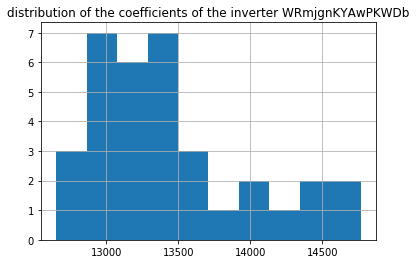

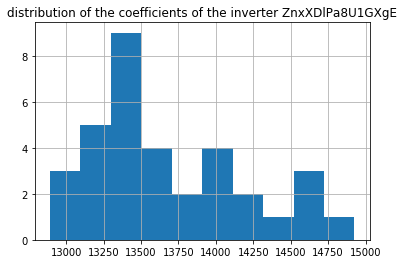

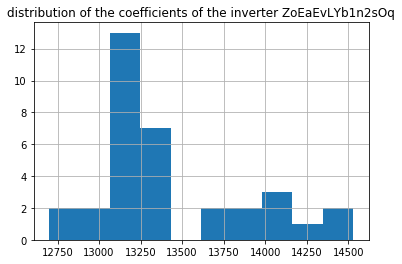

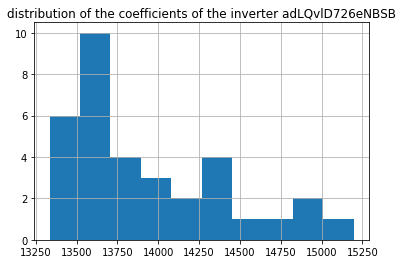

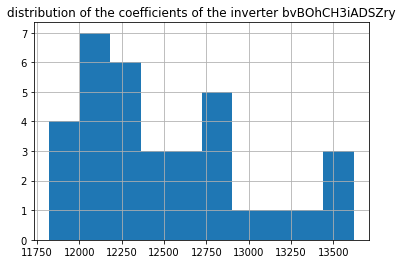

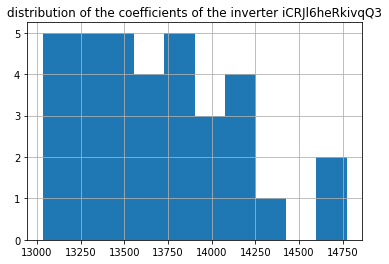

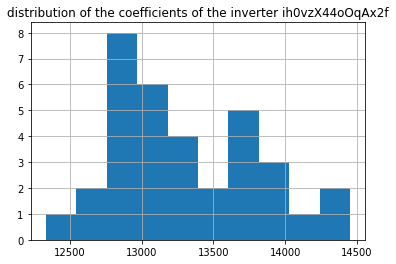

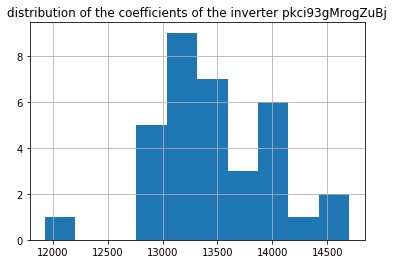

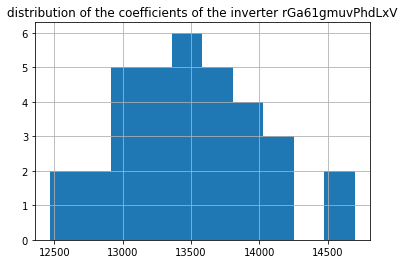

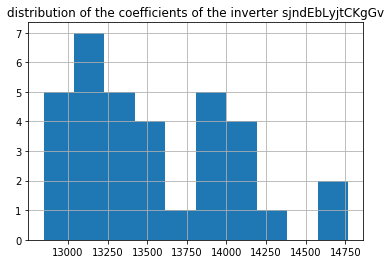

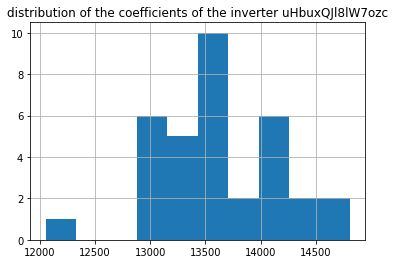

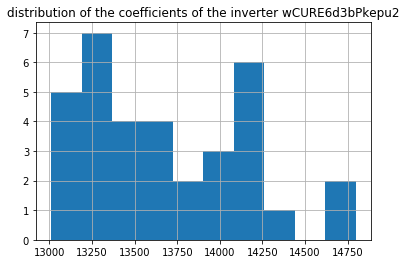

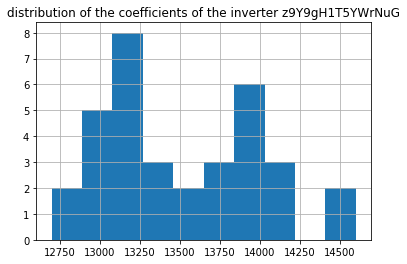

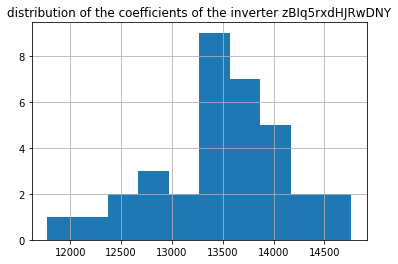

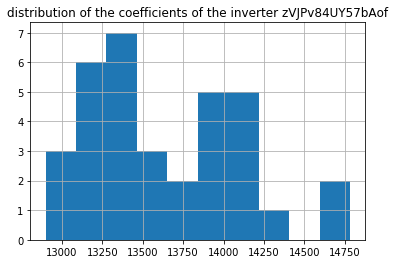

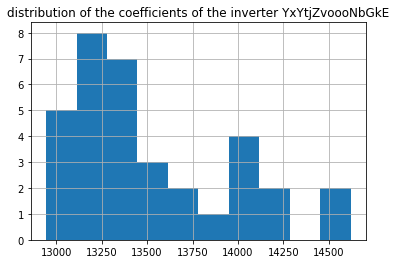

In [15]:
for i in conversion_data.Inverter.unique():
    inv=conversion_data[conversion_data.Inverter== i]
    inv.Conversion_coeff.hist()
    plt.title('distribution of the coefficients of the inverter '+ i)
    plt.show()

In [16]:
inv13=conversion_data[conversion_data.Inverter== conversion_data.Inverter.unique()[13]]
inv13[inv13.Conversion_coeff==inv13.Conversion_coeff.min()]

,Inverter,Day,Conversion_coeff
459,pkci93gMrogZuBj,153,11929.817139


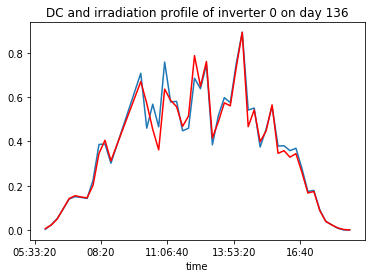

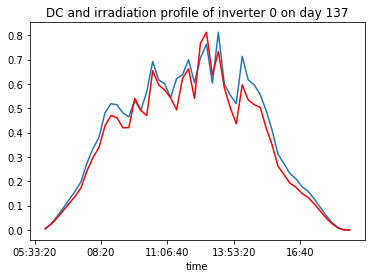

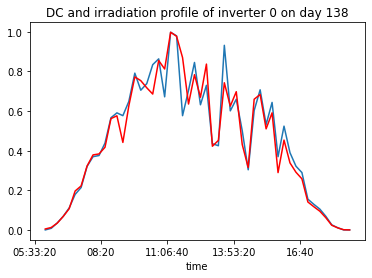

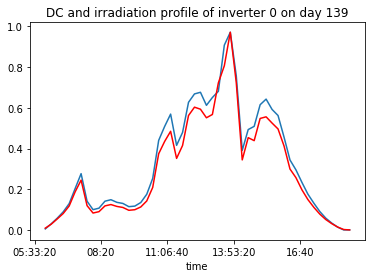

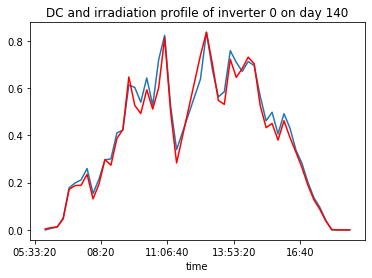

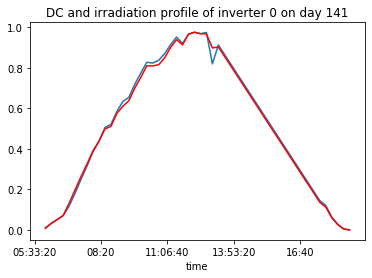

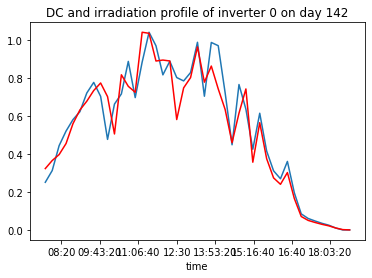

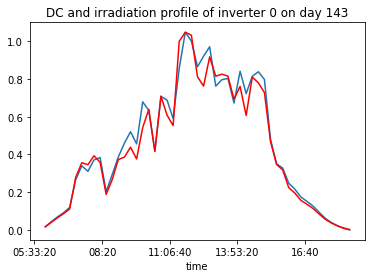

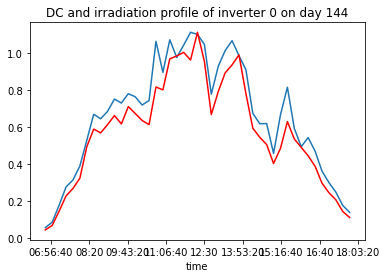

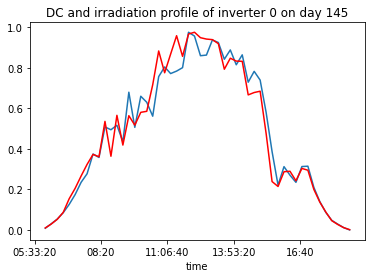

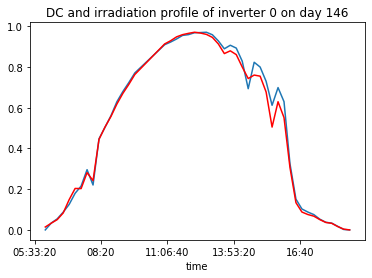

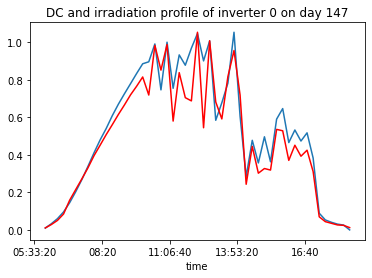

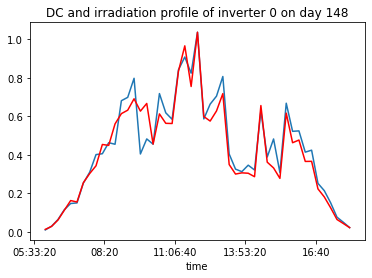

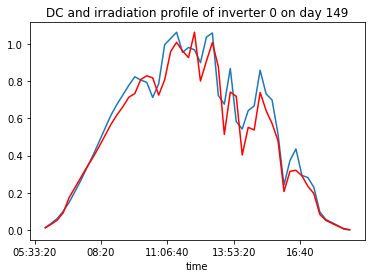

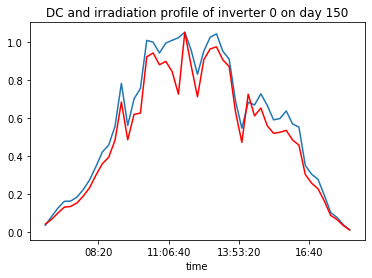

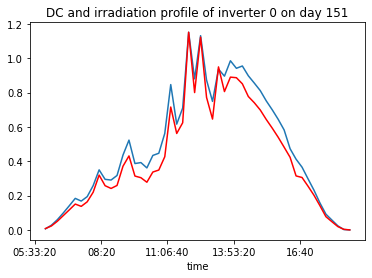

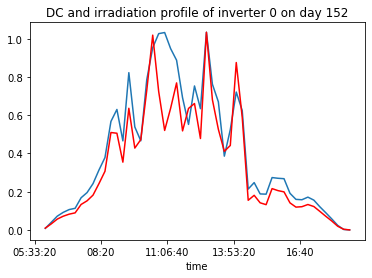

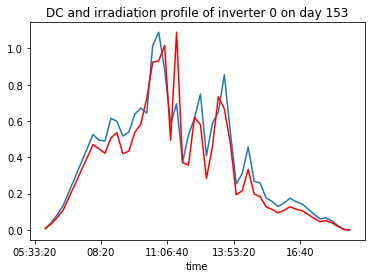

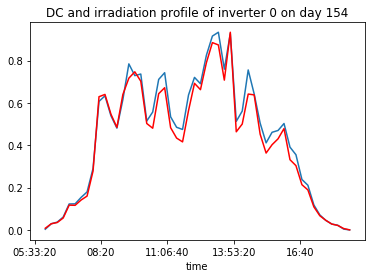

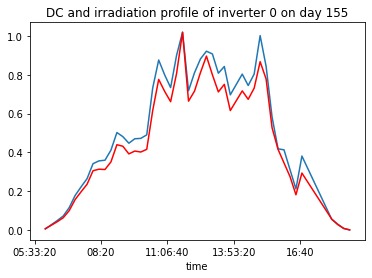

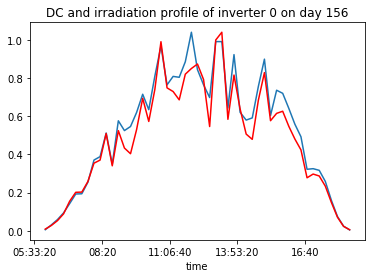

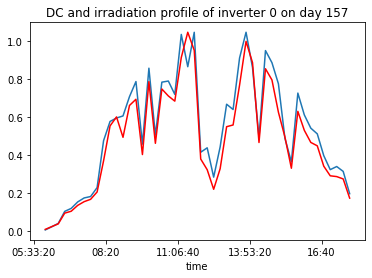

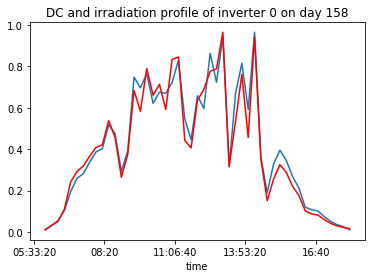

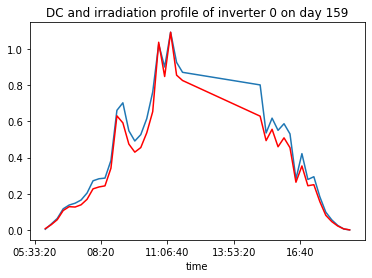

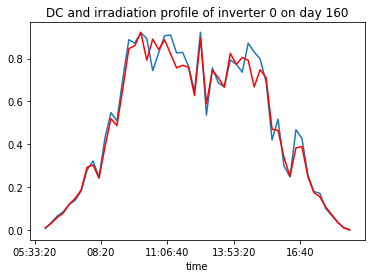

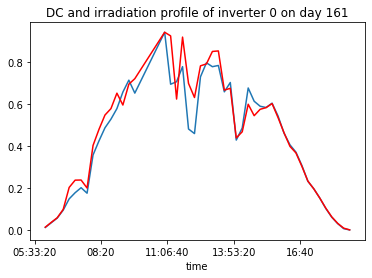

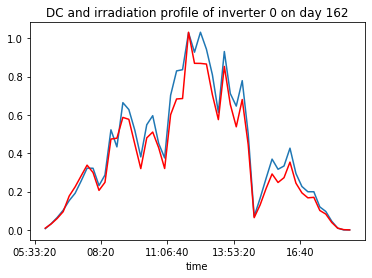

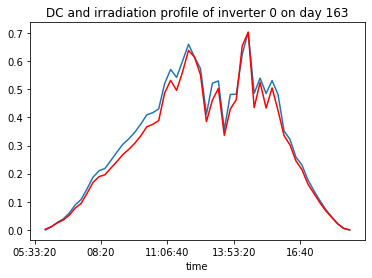

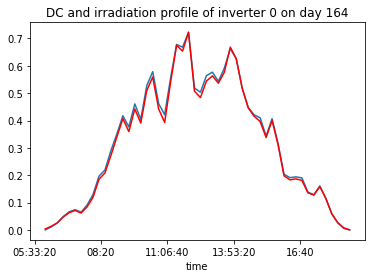

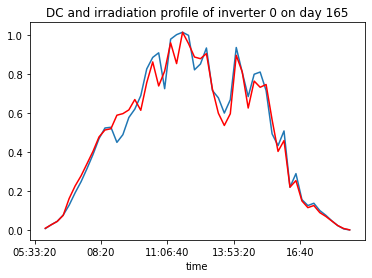

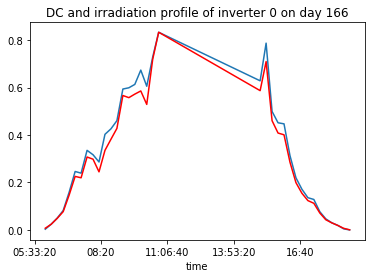

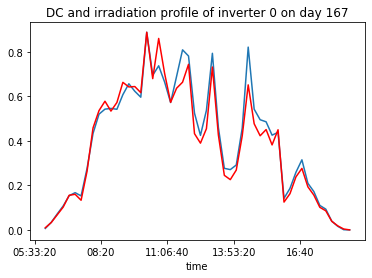

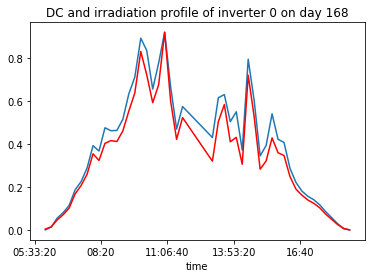

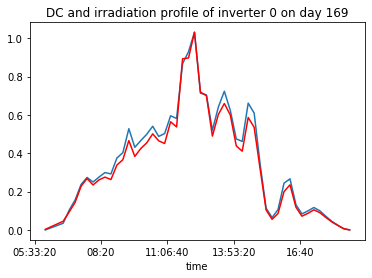

In [17]:
inverter13=clean_data[clean_data.SOURCE_KEY==conversion_data.Inverter.unique()[13]]
for a, day in inverter13.groupby(inverter13.DAY):
    scale = day.IRRADIATION.max() / day.DC_POWER.max()
    plt.plot(day.Time, day.DC_POWER*scale)
    plt.plot(day.Time, day.IRRADIATION, color='red')
    plt.title('DC and irradiation profile of inverter 0 on day '+str(a))
    plt.show()

In [18]:
day153=clean_data[clean_data.DAY==153]
day153inv13= day153[day153.SOURCE_KEY==conversion_data.Inverter.unique()[13]]

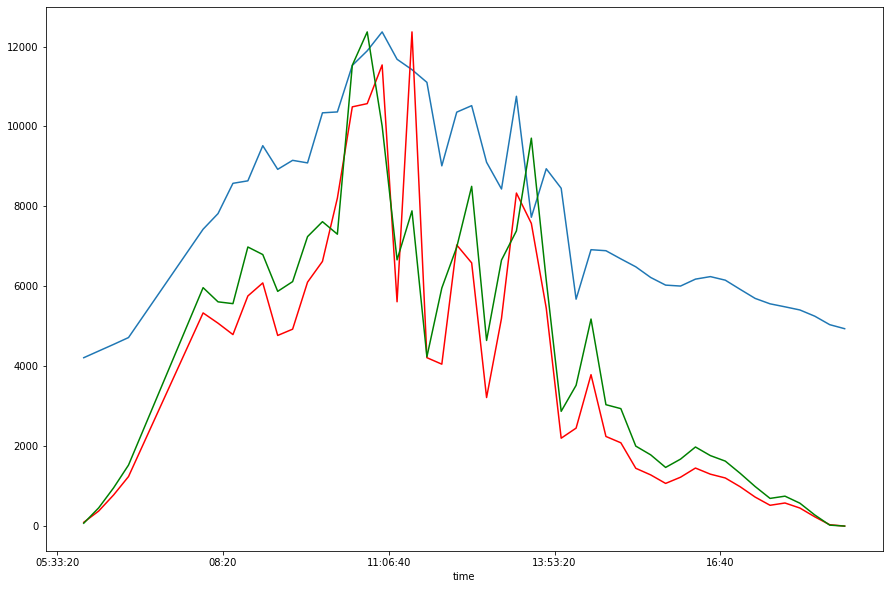

In [19]:
plt.figure(figsize=(15, 10))
scale = day153inv13.DC_POWER.max() / day153inv13.IRRADIATION.max()
scale1 = day153inv13.DC_POWER.max() / day153inv13.MODULE_TEMPERATURE.max()
plt.plot(day153inv13.Time, day153inv13.MODULE_TEMPERATURE*scale1)
plt.plot(day153inv13.Time, day153inv13.IRRADIATION*scale, color='red')
plt.plot(day153inv13.Time, day153inv13.DC_POWER , color='green')
plt.show()

I drew this plot to try and see the reason why the coefficient was low, but couldn't understand much.
I'm leaving this you notice something.